In [ ]:
import numpy as np

### Implementing [Quartic quantum speedups for planted inference](https://arxiv.org/abs/2406.19378v1)

### Problem Definition

**Definition 2.2 (simplified):**
A kXOR instance $\mathcal{I}$ on $n$ variables in ${0, 1}$ is a collection of $m$ constraints, each of the form
$$ x_{c_1} \oplus x_{c_2} \oplus ... x_{c_k} = b $$ 

**Notation 2.3**
Random Instance: Pick each clause independently:
- Pick $C$, a $k$ subset of $[n] = \{1, ... n\}$ uniformly at random.
- Pick $b \in {0, 1}$ uniformly at random.

In [ ]:
from qualtran.bloqs.max_k_xor_sat import KXorInstance, Constraint

n, k = 10, 4
cs = (
    Constraint((0, 1, 2, 3), -1), # read: x_0 ^ x_1 ^ x_2 ^ x_3 = 0
    Constraint((0, 2, 4, 5), 1),
    Constraint((0, 3, 4, 5), 1),
    Constraint((0, 3, 4, 5), 1),
    Constraint((1, 2, 3, 4), -1),
    Constraint((1, 3, 4, 5), -1),
    Constraint((1, 3, 4, 5), -1),
    Constraint((2, 3, 4, 5), 1),
)
simple_inst = KXorInstance(n, k, cs)
simple_inst

**Notation 2.4 (simplified)** Planted Instance:
Given $\rho \in [0, 1]$ (the _planted advantage_),

first pick a secret assignment $z \in \{0, 1\}^n$.
Now pick each clause independently by: 
- Pick $C$, a $k$ subset of $[n]$ uniformly at random.
- Pick noise $\eta \in {0, 1}$, s.t. $\eta = 0$ with probability $(1 + \rho)/2$
- Set $b = C(z) \oplus \eta$

Note: when $\rho = 0$, the noise is random, and when $\rho = 1$, there is no noise.

In [ ]:
random_inst = KXorInstance.random_instance(
    n=10, 
    m=20, 
    k=4,
    planted_advantage=0.8,
    rng=np.random.default_rng(42),
)
random_inst

## Problem

**Problem 2.6 (Planted Noisy kXOR)**
Given $\rho \in (0, 1)$, and an instance $\mathcal{I}$ that is promised to be either drawn from the random distribution or planted distribution (with $\rho$), distinguish which case it is.

## Kikuchi Method
This is a technique to reduce $k$XOR problems to $2$XOR problems, on an exponentially larger set of variables (say, $O(n^k)$).
The 2XOR is known to be efficiently solvable by some spectral analysis.

For this, we pick our new variables as subsets of $[n]$ of size $k$, call them $X_S$ for each subset $S$.
There are ${n \choose k}$ variables now, and for $k \ll n$, this is about $O(n^k)$.

The equations are of the form $X_S \oplus X_T = b(S, T)$ for every $S, T$ with $|S \Delta T| = k$.
Here $b(S, T)$ is the xor of all variables in S and T (common ones cancel out, leaving only the $k$ as above)

## Quantum Algorithm

**Theorem 4.18 (simplified)**
Let $k$ (even) and $\rho \in (0, 1)$ be known constants.

We are given an instance $\mathcal{I}$ which is either random or planted (with advantage $\rho$),
where the number of constraints $m$ is picked above a given threshold (see Alice Theorem).

For a parameter $\ell$, if we have a classical _Kikuchi style_ algorithm with complexity $\tilde{O}(n^\ell)$,
then there is a quantum algorithm with $\tilde{O}(n^{\ell/4} m \ell^{O{\ell}} \log^{\ell/2k}n)$.

In [15]:
from qualtran.bloqs.max_k_xor_sat.planted_noisy_kxor import PlantedNoisyKXOR
from qualtran.drawing import show_bloq, show_call_graph, show_counts_sigma

In [17]:
def make_algo_example():
    k = 4
    n, m = 100, 1000
    rho = 0.8
    
    c = 2  # Kikuchi param: ell = c * k
    
    # generate instance
    rng = np.random.default_rng(142)
    ell = c * k
    inst = KXorInstance.random_instance(n=n, m=m, k=k, planted_advantage=rho, rng=rng)
    algo_bloq = PlantedNoisyKXOR.from_inst(inst=inst, ell=ell, rho=rho, zeta=1 / np.log(n), rng=rng)

    expected_complexity = n ** (ell/4) * m * ell**ell * np.log(n)**(c//2)

    return algo_bloq, expected_complexity

In [18]:
bloq, cost_O_tilde = make_algo_example()

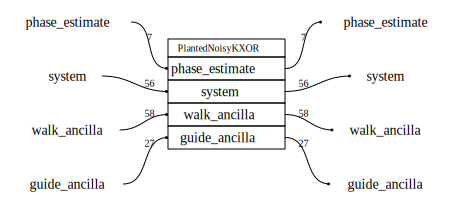

In [19]:
show_bloq(bloq)

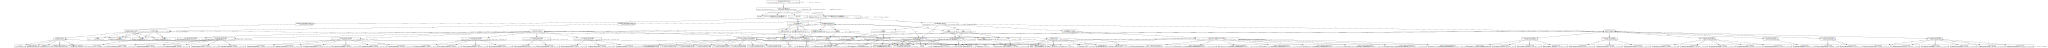

In [30]:
g, sigma = bloq.call_graph(max_depth=6)
show_call_graph(g)

In [24]:
from qualtran.resource_counting import get_cost_value, QECGatesCost

gc = get_cost_value(bloq, QECGatesCost())
gc.asdict()

{'toffoli': 12261972437984,
 'cswap': 5171509416110263,
 'and_bloq': 255058640186620068,
 'clifford': 373887003261338334,
 'rotation': 11450518379588*\tilde{O}(350784) + 17649125770113,
 'measurement': 255058640186620068}

In [25]:
(gc * (1/cost_O_tilde)).asdict()

{'toffoli': 0.0158706515045947,
 'cswap': 6.69347644605456,
 'and_bloq': 330.121994003046,
 'clifford': 483.921356116957,
 'rotation': 0.0148203878020848*\tilde{O}(350784) + 0.0228432355295913,
 'measurement': 330.121994003046}

In [29]:
f"{cost_O_tilde:e}"

'7.726193e+14'